<a href="https://colab.research.google.com/github/lovezoyaxu/car-following-model-in-mixtraffic/blob/main/mixtraffic_NN_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **import some useful lib**

In [ ]:
import scipy.io as sio
from torch import nn, optim
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import gym

In [ ]:
ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data
Ts = 0.1 # time interval for data sampling

### **Load data**
When in use choice HV-HV or HV-AV.
*Please don't click code both!*

HV follow AV

In [ ]:
# Download data
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_av_train_data.mat --output-document=trainSet.mat
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_av_test_data.mat --output-document=testSet.mat

--2024-05-20 07:33:51--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_av_train_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712807 (696K) [application/octet-stream]
Saving to: ‘trainSet.mat’

trainSet.mat        100%[===================>] 696.10K  --.-KB/s    in 0.01s   

2024-05-20 07:33:51 (62.3 MB/s) - ‘trainSet.mat’ saved [712807/712807]

--2024-05-20 07:33:51--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_av_test_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTT

HV follow HV

In [ ]:
# Download data
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_train_data.mat --output-document=trainSet.mat
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_test_data.mat --output-document=testSet.mat

--2024-05-19 07:39:57--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_train_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111996 (2.0M) [application/octet-stream]
Saving to: ‘trainSet.mat’

trainSet.mat        100%[===================>]   2.01M  --.-KB/s    in 0.08s   

2024-05-19 07:39:58 (26.4 MB/s) - ‘trainSet.mat’ saved [2111996/2111996]

--2024-05-19 07:39:58--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_test_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... conne

### **inport data in colab**

In [ ]:
# load training data
train = sio.loadmat('trainSet.mat')['calibrationData'][:, 0]
test = sio.loadmat(f'testSet.mat')['validationData'][:, 0]


check data shape

In [ ]:
train.shape

(135,)

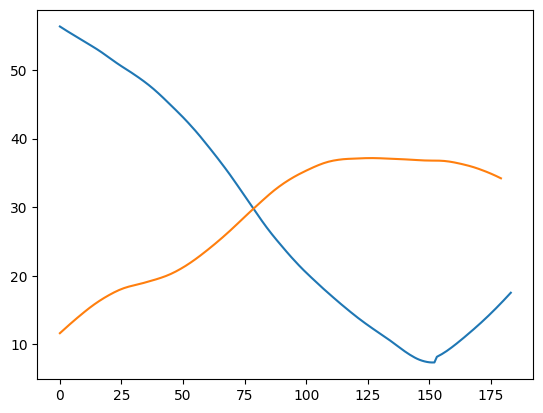

In [ ]:
plt.plot(train[0][:,0])
plt.plot(test[0][:,0])

## Define torch dataset class

In [ ]:
# Define dataset
class ImitationCarFolData(torch.utils.data.Dataset):
    """
    Dataset class for imitation learning (state -> action fitting) based car-following models.
    """
    def __init__(self, split: str, max_len = 100):
        if split == 'train':
            self.data = sio.loadmat(f'{split}Set.mat')['calibrationData'][:, 0]
        elif split == 'test':
            self.data = sio.loadmat(f'{split}Set.mat')['validationData'][:, 0]
            #self.data = self.data[0]

        self.max_len = max_len # Max length of a car following event.

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        event = self.data[idx][:self.max_len]
        #event = self.data[idx]
        acc_label = np.diff(event[:, 1])/Ts # acc
        inputs = event[:-1, :-1]
        lv_spd = event[:-1, -1]
        return {'inputs': inputs, 'label': acc_label, 'lv_spd': lv_spd}

In [ ]:
dataset = ImitationCarFolData('train')
dataset[0]['inputs'].shape, dataset[0]['label'].shape

((99, 3), (99,))

## Define backbone models

In [ ]:
# Define data-driven car-following models
class nn_model(nn.Module):
    def __init__(self, input_size = 3, hidden_size = 256):
        super(nn_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Tanh(), #[-1, 1]
            )

    def forward(self, x):
        # x: [space, relspd, speed]
        out = ACC_LIMIT*self.encoder(x)
        return out

class lstm_model(nn.Module):
    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    def __init__(self, input_size = 3, hidden_size = 32, lstm_layers = 3, dropout = 0.1):
        super(lstm_model, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first = False, dropout = dropout)
        self.linear = nn.Linear(hidden_size, 1)

        nn.init.normal_(self.linear.weight, 0, .02)
        nn.init.constant_(self.linear.bias, 0.0)

    def forward(self, src):
        # src in the shape seq_len, B, d
        enc_x, (h_n, c_n) = self.encoder(src)

        if len(h_n.shape) == 3:
            h_n = h_n[-1] # taking the last layer hidden state

        out = self.linear(h_n)
        out = torch.tanh(out)*ACC_LIMIT
        return out

class rnn_model(nn.Module):
    def __init__(self, input_size = 3, hidden_size = 32, rnn_layers = 3, dropout = 0.1):
        super(rnn_model, self).__init__()
        self.encoder = nn.RNN(input_size, hidden_size, rnn_layers, batch_first = False, dropout = dropout)
        self.linear = nn.Linear(hidden_size, 1)

        nn.init.normal_(self.linear.weight, 0, .02)
        nn.init.constant_(self.linear.bias, 0.0)

    def forward(self, src):
        # src in the shape seq_len, B, d
        enc_x, h_n = self.encoder(src)

        if len(h_n.shape) == 3:
            h_n = h_n[-1] # taking the last layer hidden state

        out = self.linear(h_n)
        out = torch.tanh(out)*ACC_LIMIT
        return out

## Open-loop training

cuda:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 1| Train Loss: 0.5191828
Epoch: 2| Train Loss: 0.5180594
Epoch: 3| Train Loss: 0.5113651
Epoch: 4| Train Loss: 0.4887626
Epoch: 5| Train Loss: 0.4860253
Epoch: 6| Train Loss: 0.4649279
Epoch: 7| Train Loss: 0.4469790
Epoch: 8| Train Loss: 0.4445337
Epoch: 9| Train Loss: 0.4258016
Epoch: 10| Train Loss: 0.3719473
Epoch: 11| Train Loss: 0.3736783
Epoch: 12| Train Loss: 0.3412081
Epoch: 13| Train Loss: 0.3131489
Epoch: 14| Train Loss: 0.2755114
Epoch: 15| Train Loss: 0.2664476
Epoch: 16| Train Loss: 0.2620096
Epoch: 17| Train Loss: 0.2541805
Epoch: 18| Train Loss: 0.2513549
Epoch: 19| Train Loss: 0.2549324
Epoch: 20| Train Loss: 0.2462779


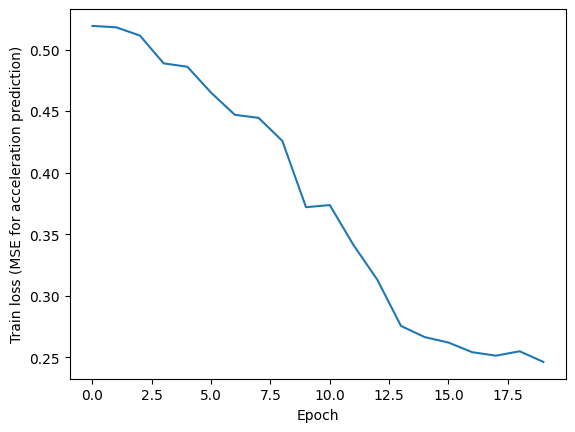

In [ ]:
# Train
train_dataset = ImitationCarFolData(split = 'train')
train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=1,
        drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model_type = 'lstm'
his_horizon = 10 # number of time steps as history data
lr = 1e-3 # learning rate
save = f'{model_type}_horizon{his_horizon}.pt'

if model_type == 'nn':
    model = nn_model(input_size = his_horizon*3).to(device)
elif model_type == 'lstm':
    model = lstm_model(input_size = 3, lstm_layers = 1).to(device) # single layer lstm
elif model_type == 'rnn':
    model = rnn_model(input_size = 3, rnn_layers = 1).to(device) # single layer rnn

model_optim = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

total_epochs = 20

train_loss_his = []
best_train_loss = None
model.train()

for epoch in range(total_epochs):
    train_losses = []

    for i, item in enumerate(train_loader):
        x_data, y_data = item['inputs'].float().to(device), item['label'].float().to(device)

        # Put T into the first dimension, B, T, d -> T, B, d
        x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)

        T, B, d = x_data.shape # (total steps, batch_size, d) as the shape of the data

        y_pre = torch.zeros(T - his_horizon, B).to(device)
        y_label = y_data[his_horizon:]

        for frame in range(his_horizon, T):
            x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
            if model_type == 'nn': # (B, his_horizon*d)
              x = x.transpose(0,1).reshape(B, -1) # flatten for history data

            acc_pre = model(x).squeeze()
            y_pre[frame - his_horizon] = acc_pre

        loss = criterion(y_pre, y_label)

        model_optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        model_optim.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    if best_train_loss is None or best_train_loss > train_loss:
        best_train_loss = train_loss
        # save the best model
        with open(save, 'wb') as f:
            torch.save(model, f)

    train_loss_his.append(train_loss)

    print("Epoch: {0}| Train Loss: {1:.7f}".format(epoch + 1, train_loss))

plt.plot(train_loss_his)
plt.xlabel('Epoch')
plt.ylabel('Train loss (MSE for acceleration prediction)');

check the result

In [ ]:
# Load the best model saved
with open(f'{save}', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()

select_segment = 7

test1 = test[select_segment]
test2 = test1[:, :3]
x_data = test1[:-1, :3]
y_data = np.diff(test2[:, 1])/Ts
lv_spd = test[select_segment][:-1,-1]

T, d = x_data.shape

x_data = torch.tensor(x_data).unsqueeze(0).float().to(device)
y_data = torch.tensor(y_data).unsqueeze(0).float().to(device)
lv_spd = torch.tensor(lv_spd).unsqueeze(0).float().to(device)
# print(x_data.shape)
# print(y_data.shape)
# print(lv_spd.shape)

x_data, y_data = x_data.transpose(0, 1), y_data.transpose(0, 1)
lv_spd = lv_spd.float().to(device).transpose(0, 1)

x_data_orig = x_data.clone().detach()
# print(x_data.shape)
# print(y_data.shape)
# print(lv_spd.shape)

for frame in range(his_horizon, T):
    x = x_data[frame-his_horizon:frame] # (his_horizon, B, d)
    if model_type == 'nn':
      x = x.transpose(0,1).reshape(1, -1) # flatten for history data

    acc_pre = model(x).squeeze()

    # update next data
    if frame < T-1:
      sv_spd_ = x_data[frame, :, 1] + acc_pre*Ts
      delta_v_ = lv_spd[frame + 1] - sv_spd_
      delta_v = x_data[frame, :, -1]
      spacing_ = x_data[frame, :, 0] + Ts*(delta_v + delta_v_)/2

      # update
      next_frame_data = torch.stack((spacing_, sv_spd_, delta_v_)).transpose(0, 1) # B, 3
      x_data[frame + 1] = next_frame_data

      # Calculating spacing error for the closed-loop simulation
spacing_pre = x_data[..., 0]
spacing_obs = x_data_orig[..., 0]


In [ ]:
# plot for one event
event_no = 0
#print(spacing_obs)
spacing_ob = spacing_obs[:, event_no].cpu().detach().numpy()
spacing_pr = spacing_pre[:, event_no].cpu().detach().numpy()
plt.plot(spacing_ob, label = 'GT')
plt.plot(spacing_pr, '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('Spacing (m)')

# speed part
plt.figure()
x_data_orig = x_data_orig[:, event_no, 1].cpu().detach().numpy()
x_data = x_data[:, event_no, 1].cpu().detach().numpy()
plt.plot(x_data_orig, label = 'GT')
plt.plot(x_data, '--', label = 'prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)')
plt.ylabel('SV speed (m/s)')
